## Download 10x scATAC dataset

In [1]:
!mkdir data
!mkdir data/5k_pbmc/

In [2]:
!wget -O ./data/5k_pbmc/fragments_atac_1.2.0_5k_pbmc.tsv.gz \
  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_fragments.tsv.gz
!wget -O ./data/5k_pbmc/fragments_atac_1.2.0_5k_pbmc.tsv.gz.tbi \
  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_fragments.tsv.gz.tbi
!wget -O ./data/5k_pbmc/peaks_atac_1.2.0_5k_pbmc.tsv \
  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_peak_annotation.tsv

--2020-08-12 21:51:24--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_fragments.tsv.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 976353254 (931M) [text/tab-separated-values]
Saving to: ‘./data/fragments_atac_1.2.0_5k_pbmc.tsv.gz’

./data/fragments_at 100%[===================>] 931.12M  39.8MB/s    in 24s     

2020-08-12 21:51:48 (39.6 MB/s) - ‘./data/fragments_atac_1.2.0_5k_pbmc.tsv.gz’ saved [976353254/976353254]

--2020-08-12 21:51:48--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_fragments.tsv.gz.tbi
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent,

In [3]:
!wget -O ./data/5k_pbmc/clusters_atac_1.2.0_5k_pbmc.tar.gz \
  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_analysis.tar.gz
!tar -xzvf ./data/5k_pbmc/clusters_atac_1.2.0_5k_pbmc.tar.gz

--2020-08-12 21:55:00--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_pbmc_5k/atac_v1_pbmc_5k_analysis.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182286803 (174M) [application/x-tar]
Saving to: ‘./data/clusters_atac_1.2.0_5k_pbmc.tar.gz’

./data/clusters_ata 100%[===================>] 173.84M  48.3MB/s    in 3.6s    

2020-08-12 21:55:14 (48.3 MB/s) - ‘./data/clusters_atac_1.2.0_5k_pbmc.tar.gz’ saved [182286803/182286803]

analysis/
analysis/lsa/
analysis/lsa/15_components/
analysis/lsa/15_components/projection.csv
analysis/lsa/15_components/components.csv
analysis/lsa/15_components/variance.csv
analysis/lsa/15_components/dispersion.csv
analysis/lsa/15_components/features_selected.csv
analysis/enrichment/
analysis/enrichment/kmeans_3_clusters/
analysis/enrichment/km

#### AtacWorks weights

In [ ]:
!mkdir models
!wget -P models https://api.ngc.nvidia.com/v2/models/nvidia/atac_dsc_atac_lowcellcount_1m_48m_50_2400/versions/0.3/files/models/model.pth.tar

In [ ]:
!pip install h5py
!pip install termcolor
!pip install configargparse
# note that I commented out the import pyBigWig line in bigwigio since I could not install pyBigWig

## Get coverages for each cluster in specific region

In [1]:
# Generic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Coverage imports
import sys
sys.path.insert(0, '..')
import coverage_gpu

# AtacWorks imports
import torch
sys.path.insert(0, '/notebooks/AtacWorks/')
from atacworks.dl4atac.layers import ZeroSamePad1d, Activation, ConvAct1d, ResBlock
from atacworks.dl4atac.models.models import DenoisingResNet
from atacworks.dl4atac.models.model_utils import load_model

# Set filepaths
CLUSTER_FILE = './data/5k_pbmc/analysis/clustering/graphclust/clusters.csv'
FRAGMENTS_FILE = './data/5k_pbmc/fragments_atac_1.2.0_5k_pbmc.tsv.gz'
GROUPING_FILE = './data/5k_pbmc/grouping_table.txt'

# Initialize AtacWorks model
model = DenoisingResNet(interval_size=50000, kernel_size=51, kernel_size_class=51)
weights_path = './models/model.pth.tar'
gpu = 0
model = load_model(model, weights_path=weights_path, rank=0)
model = model.cuda(gpu)

In [124]:
%%time
interval_start = 36800000
interval_end = 36850000

intervals = coverage_gpu.get_coverages(
    'chr1', interval_start, interval_end,
    FRAGMENTS_FILE, CLUSTER_FILE, GROUPING_FILE)
intervals = intervals[intervals['start'] < interval_end]

Tabix query took 0.36s
Reading group file took 0.00s
Filtering reads took and type conversion 0.02s
Computing cell count in group/cluster...
GroupBy cluster took 0.01s
Merging groups with reads took 0.00s
Size of interval frame:  813419
expanding reads to bp resolution took 0.03s
getting scores per bp took 0.10s
CPU times: user 292 ms, sys: 180 ms, total: 472 ms
Wall time: 543 ms


In [125]:
%%time
WINDOW_SIZE = 50000
groups = sorted(np.unique(intervals['group']))
interval_length = interval_end - interval_start
n_intervals = interval_length // WINDOW_SIZE
print("Number of inference intervals = %d" % n_intervals)
x = torch.zeros((len(groups), interval_length))

for (i, group) in enumerate(groups):
    df_group = intervals.loc[intervals['group'] == group]
#     coords = [int(c) for c in (df_group['start'] - interval_start).values]
    coords = torch.LongTensor(df_group['start']) - interval_start
    values = torch.Tensor(df_group['normalized_total'].values)
    x[i][coords] = values
    nonzero = (x[i] != 0).sum()
#     print(f"Group {group} has {nonzero} nonzero basepairs in interval")
x = x.reshape(len(groups)*n_intervals, WINDOW_SIZE)

t0 = time.time()
x = x.unsqueeze(1)
x = x.cuda(gpu, non_blocking=True)
pred = model(x)
x = x.reshape(len(groups), n_intervals*WINDOW_SIZE).cpu().detach().numpy()
track_pred = pred[0].reshape(len(groups), n_intervals*WINDOW_SIZE).cpu().detach().numpy()
peak_pred = pred[1].reshape(len(groups), n_intervals*WINDOW_SIZE).cpu().detach().numpy()
print("Inference took %.2fs" % (time.time() - t0))

Number of inference intervals = 1
Inference took 0.06s
CPU times: user 3.99 s, sys: 440 ms, total: 4.43 s
Wall time: 140 ms


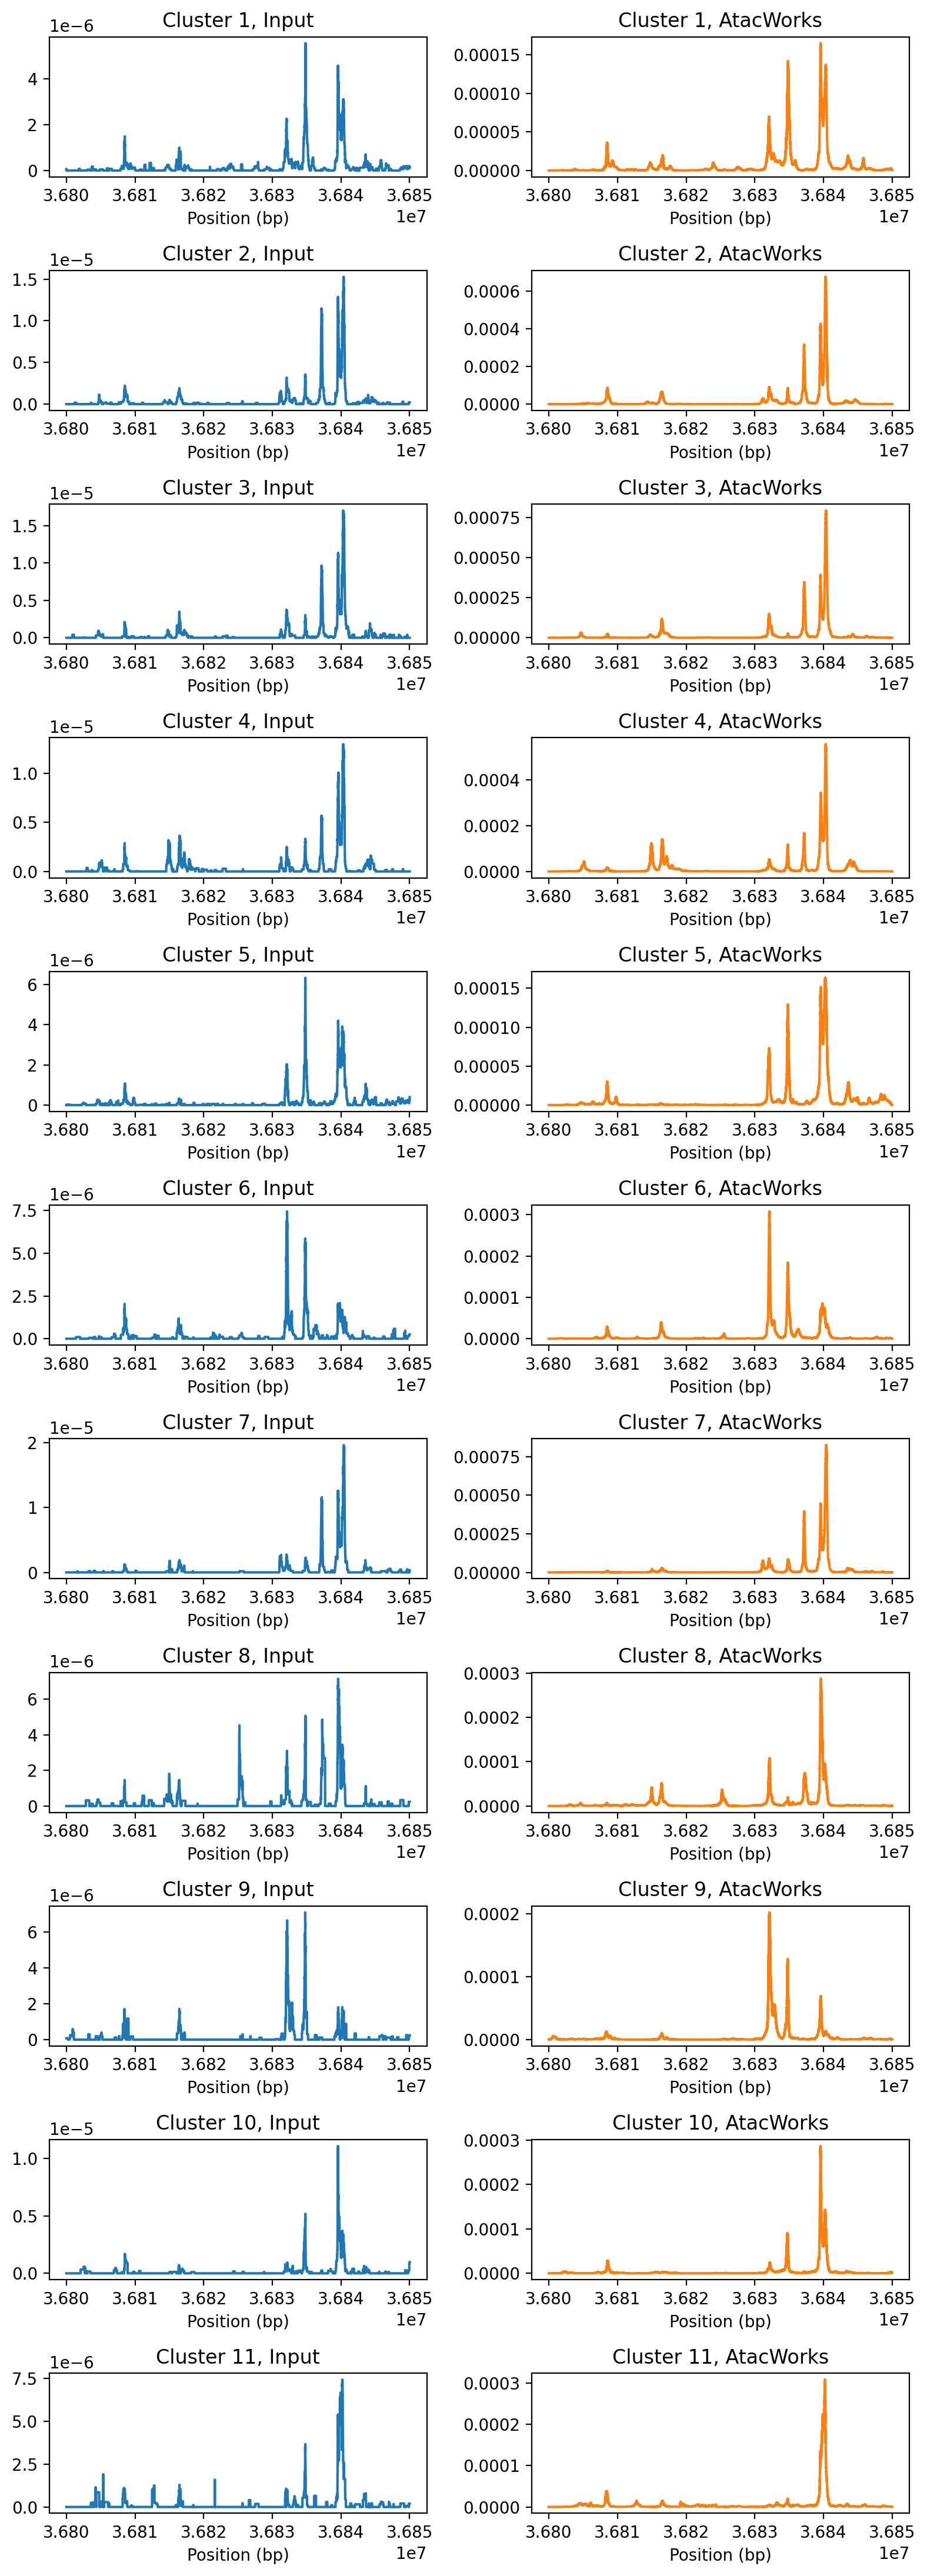

CPU times: user 3.3 s, sys: 68 ms, total: 3.36 s
Wall time: 3.36 s


In [129]:
%%time
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = len(groups), ncols = 2, figsize = (8, 2*len(groups)), dpi=200)

coords = np.arange(interval_start, interval_end)
for (i, group) in enumerate(groups):
    axs[i][0].plot(coords, x[i])
    axs[i][0].set_title(f'Cluster {group}, Input')
    axs[i][0].set_xlabel('Position (bp)')
    
    axs[i][1].plot(coords, track_pred[i], color='C1')
    axs[i][1].set_title(f'Cluster {group}, AtacWorks')
    axs[i][1].set_xlabel('Position (bp)')
    
plt.tight_layout()
plt.show()